# Analysis of King County Home Prices

**Authors:** Aaron Cherry, Ryan Reilly

![title](images/king_county_1.jpeg)

## Overview

This project analyzes data for over 21,000 home sales in King County, WA during 2014 and 2015. The goal of this analysis is to determine what features of a house drive the sale price. This will be done through exploratory daa analysis and inferential linear regression modeling of the housing data.

## Business Problem

Blue Sky Realty is a large real estate agency that helps homeowners buy/sell homes. Blue Sky has a large presence on the west coast, primarily in California and Oregon. However, they still have not expanded to Washington, until now. This will be there first office in Washington and there knowledge of what drives home prices is limited. They will be starting in King County. Since they are new to King County, they have requested our assistance to find out what feature in a home increase the sell price in the county. Through our analysis, we are going to provide recommendations to Blue Sky based on the following: 

- Where to sell a home based on recent trends
- Whether to renovate and what kinds of renovations are best
- What time of the year is best to sell homes

## Data Understanding

Each row in this dataset represents a unique home sale in King County and surrounding information about the home. There is a unique ID and sale date, along with 19 other features about the home, including the sale price, square feet, number of bedrooms, number of bathroooms, condition of home, among other features. Also included in these features is geo data of the home, which we will also explore.  

| Feature | Description|
|:------- | :-------|
|id| Unique ID for each home sold|
|date|  Date of the home sale|
|price| Price of each home sold|
|bedrooms|  Number of bedrooms|
|bathrooms|  Number of bathrooms, where .5 accounts for a room with a toilet but no shower|
|sqft_living|  Square footage of the apartments interior living space|
|sqft_lot|  Square footage of the land space|
|floors|  Number of floors|
|waterfront|  A dummy variable for whether the apartment was overlooking the waterfront or not|
|view|  An index from 0 to 4 of how good the view of the property was|
|condition|  An index from 1 to 5 on the condition of the apartment,|
|grade|  An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.|
|sqft_above|  The square footage of the interior housing space that is above ground level|
|sqft_basement|  The square footage of the interior housing space that is below ground level|
|yr_built|  The year the house was initially built|
|yr_renovated|  The year of the house’s last renovation|
|zipcode|  What zipcode area the house is in|
|lat|  Lattitude|
|long|  Longitude|
|sqft_living15|  The square footage of interior housing living space for the nearest 15 neighbors|
|sqft_lot15|  The square footage of the land lots of the nearest 15 neighbors|

#### Importing packages and loading the datasets

In [1]:
#Import standard packages for data engineering and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime

#import packages to support geo visuals
import folium
from folium.plugins import HeatMap
import json

#Import packages to perform linear regression modeling and preprocessing tools
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE

#Use the functions in the py file for preprocessing
import sys
sys.path.insert(0, 'src/')
import preprocessing


#Ignore warnings in cells
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data set
df = pd.read_csv('data/kc_house_data.csv')

#### Get an understanding of the data

In [3]:
#take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the info above, it looks like we have 21,579 rows representing home sales with 21 columns. We will have to decide how we want to treat the three columns with nulls which are waterfront, view, and yr_renovated. It's good that we have a lot of ints and floats, but we may need to convert some of these datatypes to fit our model correctly.

## Data Preparation

In [4]:
#View the first 5 rows
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [5]:
#check for duplicates 
df[df.duplicated()]

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 21 columns]

We found no duplicate rows.

#### Dealing with missing values 

In [6]:
# Confirm the three columns with missing values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
#Lets deal with waterfront first and have a look at its value counts
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

Since most homes are not on the waterfront and it does not make sense for that value to be missing (the home is either on waterfront or it isn't), lets fill the N/As with 0 and assume these homes are not waterfront homes. 

In [8]:
#Fill N/As in waterfront with 0
df['waterfront']  = df['waterfront'].fillna(0.0)

In [9]:
#Lets look at year renovated
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

Since a 0 value does not make sense for yr_renovated, we would probably mark those as NA, which would give us a total amount of NAs of 20,853 (17011 zeros + 3842 NAs). Instead, we are going to mark year renovated as 1 has been renovated) or 0 (has not been renovated). We will take care of this in feature engineering, then drop the original yr_renovated column. 

In [10]:
#Lets look at "view" value counts
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Since the most common value is 0 for indicating the view of the property, lets replace the 63 nulls with 0 as well.

In [11]:
#Fill N/As in view with 0 and convert to int.
df['view']  = df['view'].fillna(0).astype(int)

In [12]:
#Convert date into Datetime 
df['date'] = pd.to_datetime(df['date'])

This is done so we can so we can create new columns for month off of the date column to view sales by month.

In [13]:
#Convert the binary columns to ints
df['view'] = df['view'].astype('int64')
df['waterfront'] = df['waterfront'].astype('int64')

This will make it easier to preprocess these columns by converting them into integers.


In [14]:
#df['floors'] = df['floors'].astype(str)
#df['floors'] = df['floors'].str.replace('.','_')

Here we are altering floors data type so that it can be preprocessed

In [15]:
#Finally, drop ID.
df.drop(['id'],axis='columns', inplace = True)

We will not be using this column in EDA or exploratory analysis.

#### Dealing with outliers

In [16]:
#Check for outliers
df.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  2.159700e+04   
mean   5.402966e+05      3.373200      2.115826   2080.321850  1.509941e+04   
std    3.673681e+05      0.926299      0.768984    918.106125  4.141264e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068500e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21597.000000  21597.000000  21597.000000  21597.000000  21597.000000   
mean       1.494096      0.006760      0.233181      3.409825      7.657915   
std        0.539683      0.081944      0.764673      0.650546      1.173200   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above      yr_built  yr_renovated       zipcode           lat  \
count  21597.000000  21597.000000  17755.000000  21597.000000  21597.000000   
mean    1788.596842   1970.999676     83.636778  98077.951845     47.560093   
std      827.759761     29.375234    399.946414     53.513072      0.138552   
min      370.000000   1900.000000      0.000000  98001.000000     47.155900   
25%     1190.000000   1951.000000      0.000000  98033.000000     47.471100   
50%     1560.000000   1975.000000      0.000000  98065.000000     47.571800   
75%     2210.000000   1997.000000      0.000000  98118.000000     47.678000   
max     9410.000000   2015.000000   2015.000000  98199.000000     47.777600   

               long  sqft_living15     sqft_lot15  
count  21597.000000   21597.000000   21597.000000  
mean    -122.213982    1986.620318   12758.283512  
std        0.140724     685.230472   27274.441950  
min     -122.519000     399.000000     651.000000  
25%     -122.328000    1490.000000    5100.000000  
50%     -122.231000    1840.000000    7620.000000  
75%     -122.125000    2360.000000   10083.000000  
max     -121.315000    6210.000000  871200.000000

In [17]:
#Remove outliers from bedrooms
df = df[df.bedrooms != 33]

Of all the numerical variables, the one house with 33 bedrooms does not make sense because the house is only 1620 square feet. We removed this row from the dataset. There also looked to be very expensive homes in the 6-7 million dollar range but we will leave those in as there are very expensive nighborhoods in King County and those prices are realistic. 

# Feature Engineering

In [18]:
#Build function to determine if a home has been renovated 
def is_not_remodeled(x):
    if x > 0:
        return 1
    else:
        return 0

#Create the renovated column that will tell us if a home has been renovated.
df['renovated'] = df['yr_renovated'].map(is_not_remodeled)

In [19]:
#Drop the original yr_renovated column
df.drop(['yr_renovated'],axis='columns', inplace = True)

Our new renovated column may give us insight if having a renovated home will increase or decrease the price of the home. 

In [20]:
#Discretize the quality of design on the house based on Grade. 
df['quality_of_design'] = pd.cut(df.grade,bins=[0,3,10,13],labels=['low','medium','high'])

Any grade of a home that is 3 or less falls short of building contruction and design. Any grade that is 11 or above has a high quality of design. Any grade in between will have a medium quality. We will use this in exploratory analysis.

In [21]:
#Build function that will tell us if a home has a basement. 
def has_basement(x):
    if x == 0.0 or x == '?':
        return 0
    else:
        return 1

#Create a the new column
df['has_bsmt'] = df['sqft_basement'].map(has_basement)

In [22]:
#Drop the original sqft_basement column
df.drop(['sqft_basement'],axis='columns', inplace = True)

We will explore if having a basement increases price of the home. 

In [23]:
#Lets create an Age variable
df['age'] = 2016 - df['yr_built']

This will tell us old the home is which may give an indicator of sale price given age. 

In [24]:
#Drop yr_built
df.drop(['yr_built'],axis='columns', inplace = True)

In [25]:
#Create the month and month number column from the date column
df['month'] = df['date'].dt.month_name()
df['month_num'] = df['date'].dt.month

These month columns were created so we could explore seasonality in sales over the two year period of data we have. 

In [26]:

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(date):
    if isinstance(date, datetime):
        date = date.date()
    date = date.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= date <= end)

In [27]:
#Create season column
df['season'] = df['date'].map(get_season)

We created the season columnn to explore this feature that may be significant in determining sale price.

In [28]:
#Create north_south function to create north south column
def north_south(x):
    if x > 47.5:
        return 1
    else:
        return 0

#Create the column
df['north_south'] = df['lat'].map(north_south)

We will use this column in our model to see if we get improvement in predicting sale price as you move north in King County.

# Exploratory Data Analysis

#### Should a seller consider what time of year to list there home? Should a buyer consider when to buy a home?

In [29]:
#set the style of our charts
mpl.style.use('fivethirtyeight')

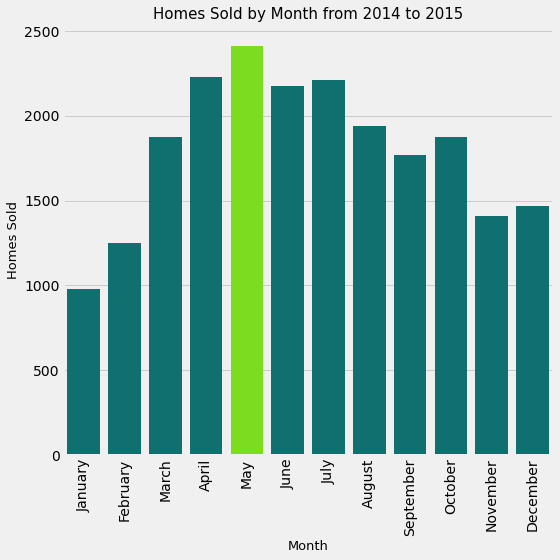

In [30]:
fig, ax = plt.subplots(figsize = (8,8))

#Create x an y and colors
y = df.groupby(['month_num','month'])['date'].count().values
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

colors = []
for month in x:
    if month == 'May':
        colors.append('#7CFC00')
    else:
        colors.append('#008080')
    

#Create the bar chart
sns.barplot(x,y, palette=colors)

#Rotate the month labels on the x axis and set labels
ax.tick_params(axis='x', labelrotation = 90)

ax.set_title('Homes Sold by Month from 2014 to 2015', fontsize = 15)
ax.set_xlabel('Month', fontsize = 13)
ax.set_ylabel('Homes Sold',fontsize = 13)

#Use tight_layout so we can save the image properly
plt.tight_layout()

fig.savefig('images/sales_per_month.png');

It looks like the most home were sold in May over the two year period of data we have. Home sales look to be hot in the spring and summer months, and slow down only slighlty in the fall and more so in the winter. 

Lets look at the number of home sales per season

In [31]:
df['season'].value_counts()

spring    6818
summer    6135
autumn    4918
winter    3725
Name: season, dtype: int64

Spring and summer have the highest sales while autumn and winter tend to have less sales. 

#### Do the number of bathrooms have an effect on the price of the house

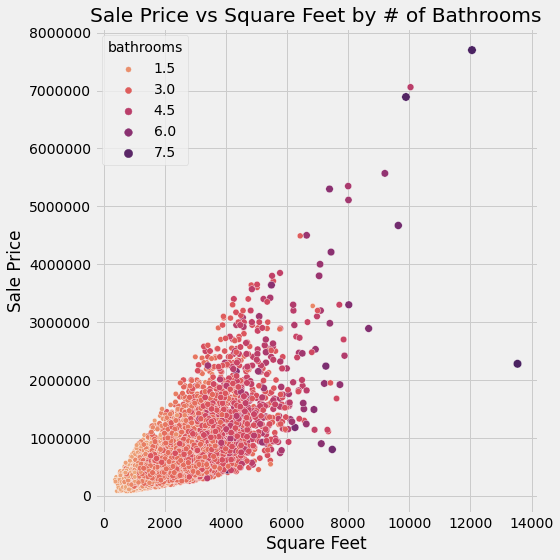

In [32]:
fig1, ax = plt.subplots(figsize = (8,8))

x1 = df['sqft_living']
y1 = df['price']
sns.scatterplot(x1,y1, hue = df['bathrooms'], size = df['bathrooms'], palette = "flare")
ax.set_xlabel("Square Feet")
ax.set_ylabel("Sale Price")
ax.set_title('Sale Price vs Square Feet by # of Bathrooms')
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.tight_layout()

fig1.savefig('images/sales_per_bathroom.png');

This scatter shows a positive relationship between square feet and sales price. You can see as the points get darker towards the top, the more bathrooms there are for a home. This shows that the number of bathrooms could help indicate a positive increase in the sale price. 

#### Would there be a great price difference whether or not a home is on the waterfront?

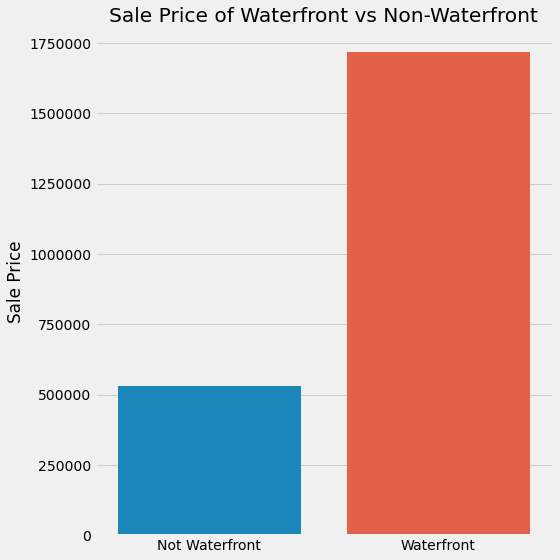

In [33]:
fig2, ax = plt.subplots(figsize = (8,8))

x1 = ['Not Waterfront', 'Waterfront']
y1 = df.groupby('waterfront').mean()['price'].values

sns.barplot(x1,y1)

ax.set_ylabel("Sale Price")
ax.set_title('Sale Price of Waterfront vs Non-Waterfront')

plt.ticklabel_format(style = 'plain', axis = 'y')
plt.tight_layout()

fig2.savefig('images/sales_per_waterfront.png');

This barchart shows that waterfront homes are significantly more expensive on average than homes not on the waterfront. Homes on the waterfront look to be 3x more expensive in King County.

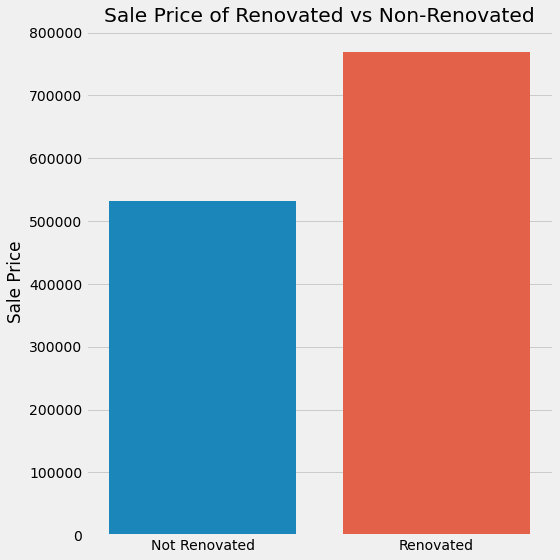

In [34]:
fig3, ax = plt.subplots(figsize = (8,8))

x1 = ['Not Renovated', 'Renovated']
y1 = df.groupby('renovated').mean()['price'].values

sns.barplot(x1,y1)

ax.set_ylabel("Sale Price")
ax.set_title('Sale Price of Renovated vs Non-Renovated')
plt.tight_layout()

fig3.savefig('images/sales_per_renovated.png');

This barchart shows that renovated homes increase the price of a home as you can see by the mean sales price of home renovated vs those that are not renovated. Renovating a home increases the average sale price by at least 25%.

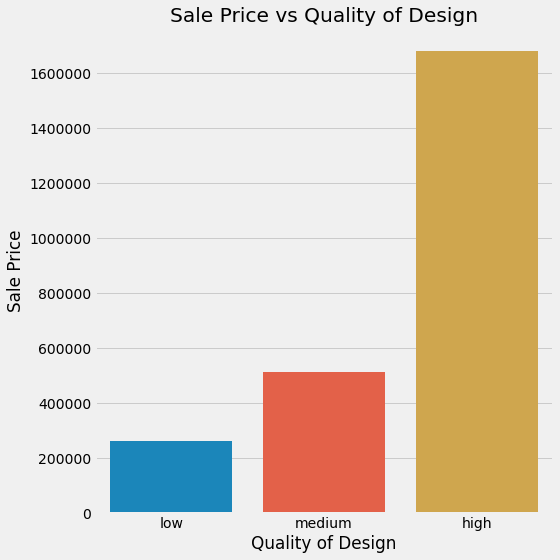

In [35]:
fig4, ax = plt.subplots(figsize = (8,8))

x1 = df.groupby('quality_of_design').mean()['price'].index
y1 = df.groupby('quality_of_design').mean()['price'].values

sns.barplot(x1,y1)
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_ylabel("Sale Price")
ax.set_xlabel("Quality of Design")
ax.set_title('Sale Price vs Quality of Design')
plt.tight_layout()

fig4.savefig('images/sales_per_design.png');

As you can see by the chart above, the quality of design matters in the sales price of a home. A low value represents a grade of 1-3, a medium quality represents a grade of 4-10, and a high qulity represents a grade of 11-13. 

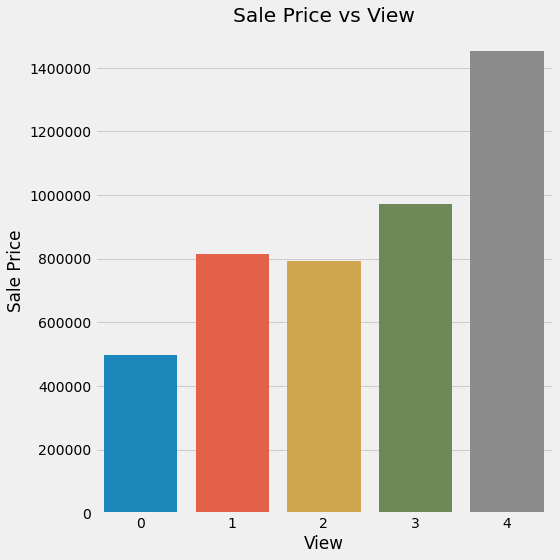

In [36]:
fig5, ax = plt.subplots(figsize = (8,8))

x1 = df.groupby('view').mean()['price'].index
y1 = df.groupby('view').mean()['price'].values

sns.barplot(x1,y1)
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_ylabel("Sale Price")
ax.set_xlabel("View")
ax.set_title('Sale Price vs View')
plt.tight_layout()

fig5.savefig('images/sales_per_view.png');

The view matters in the sale price of a home. The sales price tends to go higher as the view improves. 

#### Do prices of homes increase in certain areas of King County?

In [37]:
#Define the max value to be used in the heatmap
max_amount = df['price'].max()

#Create the basemap using the general lat, long coordinates of King County
hmap = folium.Map(location=[47.5480, -121.9836], zoom_start=10, )

#Create the heatmap
hm_wide = HeatMap(list(zip(df['lat'], df['long'], df['price'])),
                   min_opacity=0.0001,
                   max_val=max_amount,
                   radius=7, blur=10, 
                   max_zoom=1, 
                 )

#layer the heatmap over the basemap
hmap.add_child(hm_wide)


#hmap.save('images/sales_heatmap.png');

As we see from the heatmap, home prices increase as you move north in King County. The highest home prices tend to be those neighborhoods near water and closer to the downtown Seattle and Bellevue area. Particularly expensive areas include Medina, Mercer Island, Queen Ann in Seattle and Madison Park in Seattle. 

#### What is the difference in home price between North and South King County?

In [38]:
lat_price = pd.DataFrame(df.groupby('lat').mean()['price']).reset_index()
lat_price_blw = lat_price[lat_price['lat'] < 47.5]
lat_price_abv = lat_price[lat_price['lat'] > 47.5]
#plt.scatter(df.groupby('lat').mean()['price'].index,df.groupby('lat').mean()['price'].values)
lat_price_blw['price'].mean(),lat_price_abv['price'].mean()

(334510.1992331965, 628186.8186838874)

Above 47.5 degrees latitude, the average price of a home increases by 47%. Homes go from 334,510 to 628,186

#### Is there a particular zipcode that tends to sell pricier homes?

In [39]:
#bins = list(zipcode_data['price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

#We need to convert zipcode to a string so it can interact with our json file
df['zipcode'] = df['zipcode'].astype('str')

#Grab the geo json file from the king county website and save it to a folder in the repository
king_file = "geojson_files/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson"
with open(king_file, 'r') as f:
    boundary = json.load(f)

# create the folium map using general king county lat and long  
m = folium.Map(location=[47.5480, -121.9836], zoom_start=10, tiles='Stamen Toner')


# Use the groupby method to get mean value for price
zipcode_data = df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)


# Create choropleth map  
folium.Choropleth(
    geo_data=boundary,
    name='choropleth',
    data=zipcode_data,
    columns=['zipcode', 'price'],
    key_on='feature.properties.ZIPCODE',
    fill_color='Spectral',
    fill_opacity=0.6,
    nan_fill_opacity=0,
    line_opacity=1,
    #bins=bins,
    legend_name='Mean Price'
).add_to(m)

#Create popups for the area code and average price
for i in range(0,len(zipcode_data)):
    folium.Marker(
    location=[zipcode_data.iloc[i]['lat'], zipcode_data.iloc[i]['long']],
    #icon=icon,
    radius=float(15000.0),
    popup="ZipCode: "+ str(zipcode_data.iloc[i]['zipcode'])+" Average Price: $"+str(round(int(zipcode_data.iloc[i]['price']),0))
    ).add_to(m)
m


This chart shows the mean price of a home in each zipcode. The mean price tends to go up as you get closer to Bellevue, Mercer Island, and Seattle. 

# Modeling

#### First Simple Model

In [40]:
formula = 'price ~ sqft_living'
sqft_mod1 = ols(formula, df).fit()
sqft_mod1_summ = sqft_mod1.summary()
sqft_mod1_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:27:11   Log-Likelihood:            -3.0005e+05
No. Observations:               21596   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.401e+04   4410.123     -9.980      0.000   -5.27e+04   -3.54e+04
sqft_living   280.8688      1.939    144.820      0.000     277.067     284.670
==============================================================================
Omnibus:                    14801.492   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542642.481
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It looks like sqft_living is siginificant in determining the sale price of a house. For every one square foot increase, the sale price increases by $280. There is a very small p value for sqft_living and the R squared is condierable at .493.

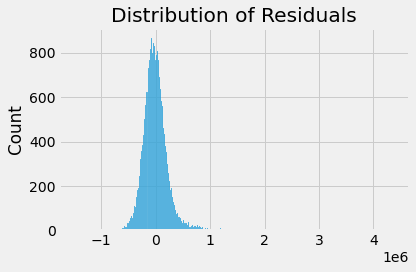

In [41]:
#Check for the normal distirbustion of residuals
fig6, ax = plt.subplots()

sqft_mod1_residuals = sqft_mod1.resid
sns.histplot(sqft_mod1_residuals).set_title("Distribution of Residuals")
plt.tight_layout()
fig6.savefig('images/model_1_residuals.png');

The errors look to be normaly distibuted.

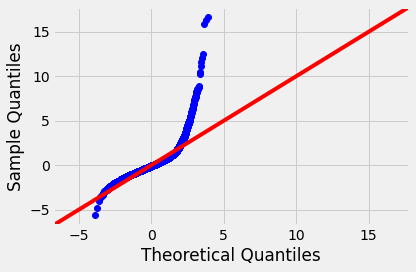

In [42]:
#Create qq plot
fig7 = sm.graphics.qqplot(sqft_mod1_residuals, dist=stats.norm, line='45', fit=True)
plt.tight_layout()
fig7.savefig('images/model_1_qq.png');

It looks like the qq plot is showing a right skewed data by looking at the blue line going in an upworkd direction . This violates our assumption of normal distributions so we may want to take the log of one or both of these variables. 

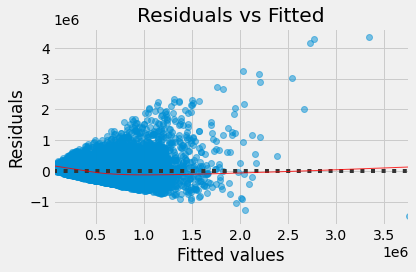

In [43]:
# model values
model1_fitted_y = sqft_mod1.fittedvalues
# model residuals
model1_residuals = sqft_mod1.resid


#plot_lm_1 = plt.figure()

plot_lm_1 = sns.residplot(model1_fitted_y, model1_residuals, data=df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.set_title('Residuals vs Fitted')
plot_lm_1.set_xlabel('Fitted values')
plot_lm_1.set_ylabel('Residuals')
plt.tight_layout()
plt.savefig('images/model_1_homoskedasticity.png');

Seeing the cone shape of the data, the data looks to be heteroskedastik which violates the assumption of homoskedasticity. 

#### Lets look to transform some varaibles that do not look to be normally distributed. 

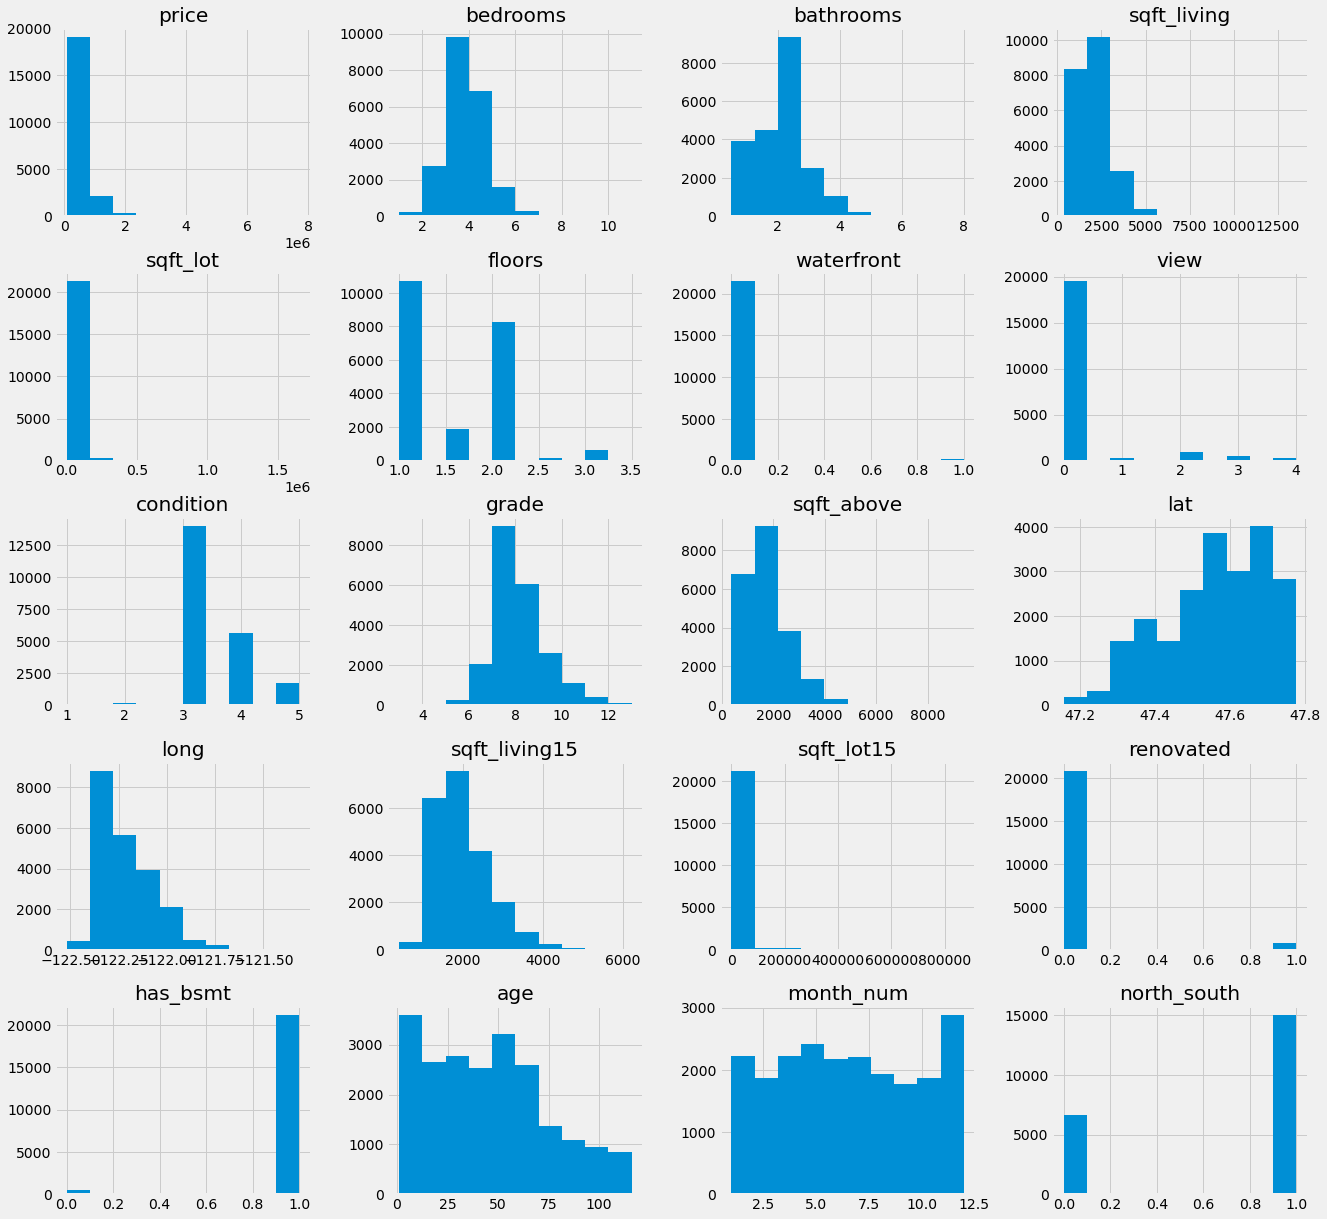

In [44]:
#Create a histogram of the variables
df.hist(figsize = (20,20));

It looks like we will need to transform the following variables because they are all heavily right positive skewed. We will be using a log transformation. 

- price 
- sqft_living 
- sqft_living15 
- sqft_lot
- sqft_lot15 
- sqft_above 
- age 

In [45]:
#Use for loop to transform all continuous variables so they have a normal distirbution
continuous = ['price','sqft_living','sqft_above','sqft_living15','sqft_lot15']
data_log_scaled = preprocessing.log_scaled(data=df,features=continuous)

The above code is using a function to apply log transformations and normalization to continuous variables we specify. The function was built in our src file.

#### One-hot encoding the categorical variables with more than two categories. 

In [46]:
#Use for loop to transform all categorical variables
categoricals = ['season']
data_ohe = preprocessing.ohe_categoricals(data=df,features=categoricals)

In [47]:
#Concatonate the continuous and categorical variables.
data_pp = pd.concat([data_log_scaled,data_ohe, df[['waterfront', 'has_bsmt', 'renovated', 'bedrooms', 'bathrooms', 'condition','floors','grade', 'view', 'north_south', 'age']]],axis=1)

Here we create a dataframe called data_pp off of the continuous and categorical variables.

#### 2nd Model using log of both price and square feet

In [48]:
formula = 'log_price ~ log_sqft_living'
sqft_mod2 = ols(formula, data_pp).fit()
sqft_mod2_summ = sqft_mod2.summary()
sqft_mod2_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:27:14   Log-Likelihood:                -24082.
No. Observations:               21596   AIC:                         4.817e+04
Df Residuals:                   21594   BIC:                         4.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7.908e-16      0.005  -1.57e-13      1.000      -0.010       0.010
log_sqft_living     0.6748      0.005    134.372      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.586   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.131
Skew:                           0.143   Prob(JB):                     1.65e-25
Kurtosis:                       2.788   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

GIven the R squared value of .455 and the P_value of 0 for the log_sqft_living, we can say that the square feet of the house is statistically significant in determining the price of a home. 

In [49]:
lr_model1 = LinearRegression()

lr_model1.fit(data_pp[['log_sqft_living']], data_pp['log_price'])

lr_model1.score(data_pp[['log_sqft_living']], data_pp['log_price'])

0.45538255333874944

Using sklearn above, we get the same R squared.

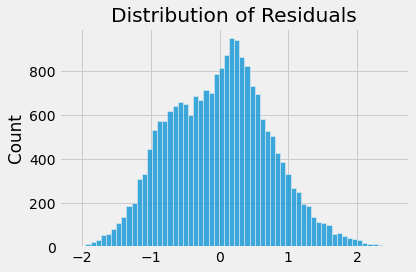

In [50]:
#Check for the normal distirbustion of residuals
fig6, ax = plt.subplots()

sqft_mod2_residuals = sqft_mod2.resid
sns.histplot(sqft_mod2_residuals).set_title("Distribution of Residuals")
plt.tight_layout()
fig6.savefig('images/model_1b_residuals.png');

 The errors follow a normal distribution.

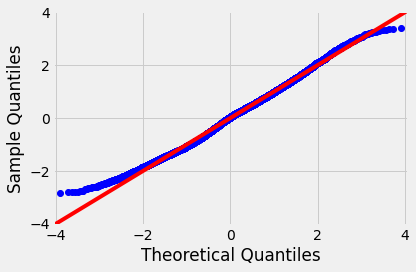

In [51]:
#Create qq plot
fig7 = sm.graphics.qqplot(sqft_mod2_residuals, dist=stats.norm, line='45', fit=True)
plt.tight_layout()
fig7.savefig('images/model_1b_qq.png');

 The quantiles of normal data appear mostly as a straight line which also validates our normal distribution of errors. 

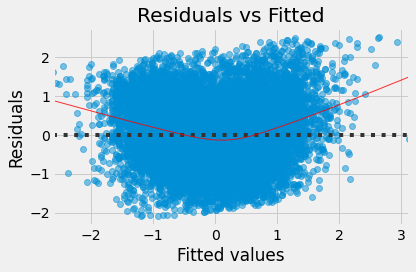

In [52]:
# model values
model_fitted_y = sqft_mod2.fittedvalues
# model residuals
model2_residuals = sqft_mod2.resid


#plot_lm_1 = plt.figure()

plot_lm_1 = sns.residplot(model_fitted_y, model2_residuals, data=data_pp,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.set_title('Residuals vs Fitted')
plot_lm_1.set_xlabel('Fitted values')
plot_lm_1.set_ylabel('Residuals')
plt.tight_layout()
plt.savefig('images/model_1b_homoskedasticity.png');


It appears the data are homoskedastic, which is good because it indicates that a the price's variability is equal across values of the square_feet.

#### 3rd Model with more predictors that have a high correlation with price

In [53]:
outcome = 'log_price'
x_cols = list(data_pp.columns[1:])


# Fitting the model
predictors = '+'.join(x_cols)
mult_formula = outcome + '~' + predictors
mult_model = ols(formula=mult_formula, data=data_pp).fit()
mult_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     4480.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:27:15   Log-Likelihood:                -13847.
No. Observations:               21596   AIC:                         2.773e+04
Df Residuals:                   21577   BIC:                         2.788e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.6756      0.052    -70.181      0.000      -3.778      -3.573
log_sqft_living       0.2536      0.009     29.208      0.000       0.237       0.271
log_sqft_above        0.0501      0.008      6.272      0.000       0.034       0.066
log_sqft_living15     0.1211      0.005     23.211      0.000       0.111       0.131
log_sqft_lot15       -0.0028      0.004     -0.697      0.486      -0.011       0.005
season_autumn         0.0796      0.009      9.252      0.000       0.063       0.096
season_spring         0.0017      0.009      0.193      0.847      -0.016       0.019
season_summer         0.0464      0.010      4.640      0.000       0.027       0.066
waterfront            0.8418      0.041     20.307      0.000       0.761       0.923
has_bsmt             -0.0041      0.022     -0.188      0.851      -0.047       0.039
renovated             0.1404      0.018      7.745      0.000       0.105       0.176
bedrooms             -0.0483      0.005    -10.280      0.000      -0.058      -0.039
bathrooms             0.1216      0.007     16.531      0.000       0.107       0.136
condition             0.1170      0.005     21.973      0.000       0.107       0.127
floors                0.0562      0.009      6.341      0.000       0.039       0.074
grade                 0.2831      0.005     59.548      0.000       0.274       0.292
view                  0.1058      0.005     22.352      0.000       0.097       0.115
north_south           0.8543      0.008    113.131      0.000       0.839       0.869
age                   0.0061      0.000     39.331      0.000       0.006       0.006
==============================================================================
Omnibus:                      542.487   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1237.125
Skew:                           0.093   Prob(JB):                    2.30e-269
Kurtosis:                       4.158   Cond. No.                         930.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at R sqaured, we improved our model significantly to .778. However, we are concerned about high multicollinearity of the model since we have a lot of similer features (i.e sqft_living and sqft_lot15. We will check for multicollinearity after our residual plots. 

In [54]:
lr_model2 = LinearRegression()

lr_model2.fit(data_pp[x_cols], data_pp['log_price'])

lr_model2.score(data_pp[x_cols], data_pp['log_price'])

0.7889115135105937

Using sklearn, we get the same R Squared.

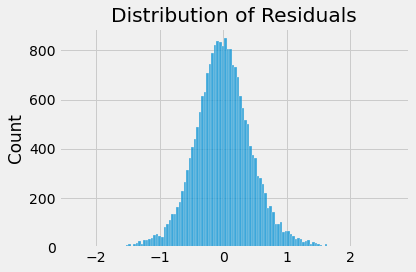

In [55]:
#Check for the normal distirbustion of residuals
fig8, ax = plt.subplots()

mult_model_residuals = mult_model.resid
sns.histplot(mult_model_residuals).set_title("Distribution of Residuals")
plt.tight_layout()
fig8.savefig('images/model_2_residuals.png');

 The errors follow a normal distribution.

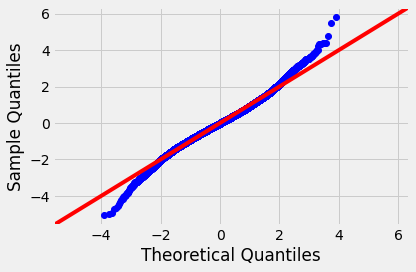

In [56]:
#Create qq plot
fig9 = sm.graphics.qqplot(mult_model_residuals, dist=stats.norm, line='45', fit=True)
plt.tight_layout()
fig9.savefig('images/model_2_qq.png');

 The quantiles of normal data appear mostly as a straight line which also validates our normal distribution of errors.

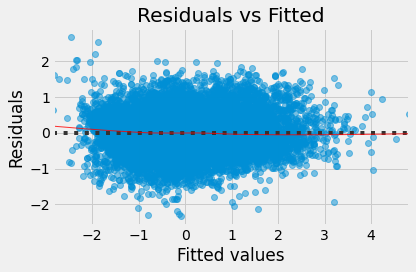

In [57]:
# model values
model_fitted_y = mult_model.fittedvalues
# model residuals
model_residuals = mult_model.resid


plot_lm_1 = sns.residplot(model_fitted_y, model_residuals, data=data_pp,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.set_title('Residuals vs Fitted')
plot_lm_1.set_xlabel('Fitted values')
plot_lm_1.set_ylabel('Residuals')
plt.tight_layout()
plt.savefig('images/model_2_homoskedasticity.png');

It appears the data are homoskedastic, which is good because it indicates that a the price's variability is equal across values of the predictors.

In [58]:
#Check the ranking of the predictors from Model 2
mult = mult_model.pvalues.sort_values()
mult = pd.DataFrame(mult, columns = ['P-Value']).reset_index()
mult.rename(columns = {'index': 'Predictor'}, inplace = True)
mult

Predictor        P-Value
0           Intercept   0.000000e+00
1               grade   0.000000e+00
2         north_south   0.000000e+00
3                 age   0.000000e+00
4     log_sqft_living  5.787316e-184
5   log_sqft_living15  9.763848e-118
6                view  1.998853e-109
7           condition  7.527326e-106
8          waterfront   7.854031e-91
9           bathrooms   5.185381e-61
10           bedrooms   9.864688e-25
11      season_autumn   2.396616e-20
12          renovated   9.941854e-15
13             floors   2.328038e-10
14     log_sqft_above   3.623703e-10
15      season_summer   3.496431e-06
16     log_sqft_lot15   4.858340e-01
17      season_spring   8.470287e-01
18           has_bsmt   8.509426e-01

Above we ranked the predictors of model 2. The featurs that do not have a P value below .05 include has_bsmt, log_sqft_above. We will look to drop these in our 3rd model.

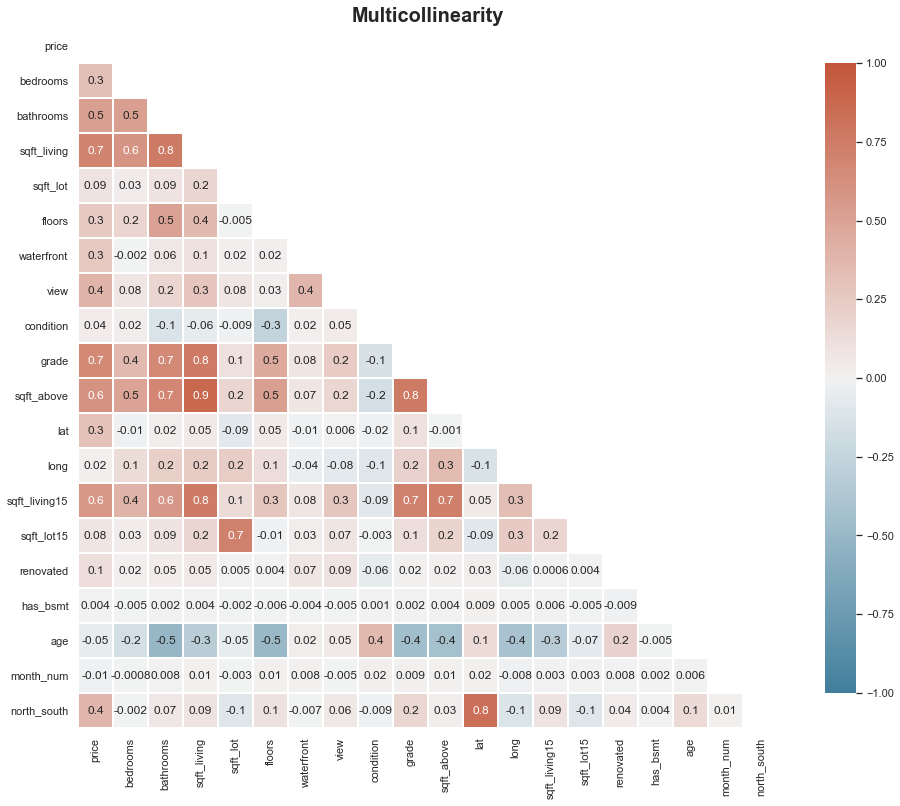

In [59]:
#Check for Multicolinearity
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig10, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9}, annot = True, fmt = '0.1g')
ax.set_title('Multicollinearity',fontweight="bold", size=20)
plt.savefig('images/model_2_multicollinearity.png');

There looks to be a number of variables that are highly correlated with eachother. Lets look a the pairs of variables that are highly correlated.

In [60]:
#Lets look at the pairs of variables that are highly correlated

dfcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

dfcorr['pairs'] = list(zip(dfcorr.level_0, dfcorr.level_1))

dfcorr.set_index(['pairs'], inplace = True)

dfcorr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
dfcorr.columns = ['cc']

dfcorr.drop_duplicates(inplace=True)

dfcorr[(dfcorr.cc>.75) & (dfcorr.cc<1)]

cc
pairs                                 
(sqft_above, sqft_living)     0.876448
(north_south, lat)            0.832996
(sqft_living, grade)          0.762776
(sqft_living, sqft_living15)  0.756400
(grade, sqft_above)           0.756069
(bathrooms, sqft_living)      0.755755

It looks like sqft_living is highly correlated with a number of variables.

- We will look to remove sqft_above from our next model because of its high correlation with sqft_living. Most home do not have a basement, so the sqft_above is close to the same as sqft_living. 

- We will also look to remove sqft_living15 from our next model. It is also highly coorelated. 

- north_south was created from the lat column, so we will remove lat from the model.

#### 4th Model where we drop features based on high multicollinearity and high p values

In [61]:
outcome = 'log_price'
x_cols2 = list(data_pp.drop(['log_price', 'has_bsmt', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15', 'bedrooms','bathrooms','floors'], axis=1).columns)


# Fitting the model
predictors = '+'.join(x_cols2)
mult_formula2 = outcome + '~' + predictors
mult_model2 = ols(formula=mult_formula2, data=data_pp).fit()
mult_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     6878.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:27:33   Log-Likelihood:                -14389.
No. Observations:               21596   AIC:                         2.880e+04
Df Residuals:                   21584   BIC:                         2.890e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8461      0.040    -95.190      0.000      -3.925      -3.767
log_sqft_living     0.3711      0.005     76.186      0.000       0.362       0.381
season_autumn       0.0817      0.009      9.269      0.000       0.064       0.099
season_spring       0.0067      0.009      0.744      0.457      -0.011       0.024
season_summer       0.0444      0.010      4.339      0.000       0.024       0.065
waterfront          0.8515      0.042     20.089      0.000       0.768       0.935
renovated           0.1729      0.018      9.403      0.000       0.137       0.209
condition           0.1065      0.005     19.719      0.000       0.096       0.117
grade               0.3404      0.004     75.806      0.000       0.332       0.349
view                0.1192      0.005     25.010      0.000       0.110       0.129
north_south         0.8663      0.007    117.636      0.000       0.852       0.881
age                 0.0044      0.000     31.415      0.000       0.004       0.005
==============================================================================
Omnibus:                      579.622   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1306.400
Skew:                           0.125   Prob(JB):                    2.08e-284
Kurtosis:                       4.179   Cond. No.                         717.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
mult_model2_coeff = dict(zip(mult_model2.params.index,abs(mult_model2.params.values)))
mult_model2_coeff = {k: v for k, v in sorted(mult_model2_coeff.items(), key=lambda item: item[1])}

In [63]:
def calculate_percentage(df_dict):
    percents = []
    for k,v in df_dict.items():
        if k.startswith('log_'):
            percent = ((1.1)**v - 1)*100
        else:
            percent = (np.exp(v) - 1)*100
        percents.append(percent)
    return percents
percentages = calculate_percentage(mult_model2_coeff)
percentages_dict = dict(zip(mult_model2_coeff.keys(),percentages))
percentages_dict

{'age': 0.4459428596861992,
 'season_spring': 0.6738393364393858,
 'season_summer': 4.544833816088523,
 'season_autumn': 8.516537290861613,
 'condition': 11.235462944083485,
 'view': 12.664672866342453,
 'renovated': 18.86910681677696,
 'grade': 40.54656394741543,
 'log_sqft_living': 3.6001579765049696,
 'waterfront': 134.32681970781593,
 'north_south': 137.8193595948609,
 'Intercept': 4581.1523907556975}

This is the final model we will use in our presentation becauase we are not violating model assumptions and we have a good set of variables with a low p values. Below are some interpretations of the most significant features: 


 - north_south: The expected percent increase in mean price from living in the south to living in the north is 137%
 - Waterfront: The expected percent increase in mean price from not having waterfront to having waterfront is 134%
 - Renovated: The expected percent increase in mean price from not having a renovated home to having a renovated home is 19%
 - Square foot: for every 10% increase in square footage, the price of the home will increase by 3.6% 
 - Grade: The expected percent increase in mean price from increasing the grade on your house by one level is 41%
 - Condition: The expected percent increase in the mean price from increasing the condition score by one level is 11%
 - Age: For every year older the home is, the value will decrease by .4%
 - Season: There is an 8.5% increase in the average price of the house in the Autumn season as opposed to any other season. 

Above are the features along with the percentages of each feature when speaking about its significance to sale price. 

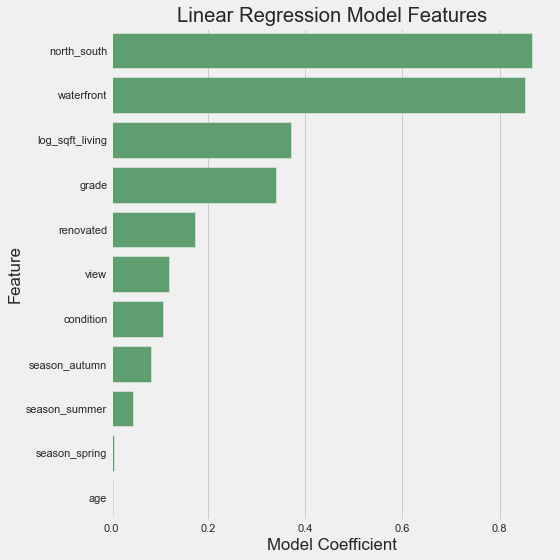

In [64]:
mpl.style.use('fivethirtyeight')
# Display the most significant features
mult_model2_coeff = dict(zip(x_cols2,abs(mult_model2.params[1:])))
mult_model2_coeff = {k: v for k, v in sorted(mult_model2_coeff.items(), key=lambda item: item[1], reverse = True)}
#plt.barh(list(mult_model2_coeff.keys()),list(mult_model2_coeff.values()))

fig4, ax = plt.subplots(figsize = (8,8))


sns.barplot(y=list(mult_model2_coeff.keys()),x=list(mult_model2_coeff.values()), color = 'g')

ax.set_ylabel("Feature")
ax.set_xlabel("Model Coefficient")
ax.set_title('Linear Regression Model Features')
plt.tight_layout()

plt.savefig('images/model_features.png');


In [65]:
#Run the model in sklearn
lr_model3 = LinearRegression()

lr_model3.fit(data_pp[x_cols2], data_pp['log_price'])

lr_model3.score(data_pp[x_cols2], data_pp['log_price'])

0.7780425046234467

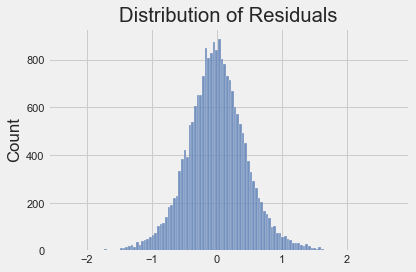

In [66]:
#Check for the normal distirbustion of residuals
fig10, ax = plt.subplots()

mult_model2_residuals = mult_model2.resid
sns.histplot(mult_model2_residuals).set_title("Distribution of Residuals")
plt.tight_layout()
fig8.savefig('images/model_3_residuals.png');

Errors of model look to me normally distirbuted

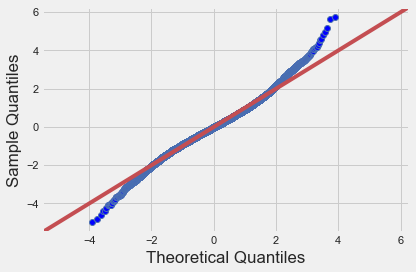

In [67]:
#Create qq plot
fig11 = sm.graphics.qqplot(mult_model2_residuals, dist=stats.norm, line='45', fit=True)
plt.tight_layout()
fig11.savefig('images/model_3_qq.png');

 The quantiles of normal data appear mostly as a straight line which also validates our normal distribution of errors.

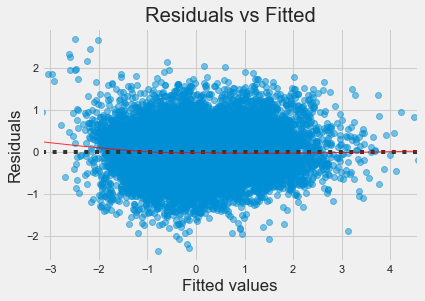

In [68]:
# model values
model_fitted_y = mult_model2.fittedvalues
# model residuals
model_residuals = mult_model2.resid


plot_lm_1 = sns.residplot(model_fitted_y, model_residuals, data=data_pp,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.set_title('Residuals vs Fitted')
plot_lm_1.set_xlabel('Fitted values')
plot_lm_1.set_ylabel('Residuals')

plt.savefig('images/model_3_homoskedasticity.png');

It appears the data are homoskedastic, which is good because it indicates that a the price's variability is equal across values of the predictors.

#### 5th model using polynomials

In [69]:
pf = PolynomialFeatures(degree=2)

X = data_pp.drop(['log_price', 'has_bsmt', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15', 'bedrooms','bathrooms','floors'], axis=1)
y = data_pp['log_price']

# Fitting the PolynomialFeatures object
pf.fit(X)


PolynomialFeatures()

In [70]:
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names(X.columns))

In [71]:
lr = LinearRegression()

lr.fit(pdf, y)

LinearRegression()

In [72]:
lr.score(pdf, y)

0.7921365272453033

After trying every possible product of features using a degree of 2, our R squared improved to .82, which is our best yet, but the model is harder to interpret as we are looking at every possible interaction between the varaibles. 

It looks like our r_squared score improved significantly from model 2 with a score of .611.

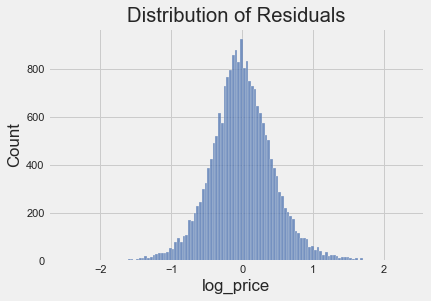

In [73]:
#Check for the normal distirbustion of residuals
prediction = lr.predict(pdf)
residual = (y - prediction)
poly_model_residuals = residual
sns.histplot(poly_model_residuals).set_title("Distribution of Residuals")
plt.savefig('images/model_4_residuals.png');

The distribution of errors look to be normal.

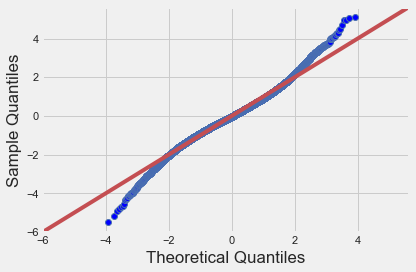

In [74]:
#Create qq plot
fig10 = sm.graphics.qqplot(poly_model_residuals, dist=stats.norm, line='45', fit=True)
plt.tight_layout()
fig10.savefig('images/model_4_qq.png');

This QQ plot re-iterates the normal distribution of errors. 

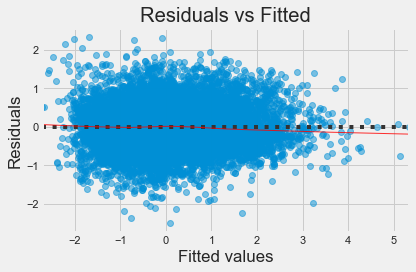

In [75]:
#Check for homoskedasticity

plot_lm_1 = sns.residplot(prediction, poly_model_residuals, data=pdf,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.set_title('Residuals vs Fitted')
plot_lm_1.set_xlabel('Fitted values')
plot_lm_1.set_ylabel('Residuals')
plt.tight_layout()
plt.savefig('images/model_4_homoskedasticity.png');

It appears the data for the 3rd model are homoskedastic, which is good because it indicates that a the price's variability is equal across values of the polynomial features.

####  Lets run a sanity check uning recursive feature elimination to see which variables do a good job of predicting price.

In [76]:
lr_rfe = LinearRegression()
select = RFE(lr, n_features_to_select=3)

In [77]:
ss = StandardScaler()
ss.fit(X)

features_scaled = ss.transform(X)

In [78]:
select.fit(X=features_scaled, y=data_pp['log_price'])

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [79]:
X.head()

log_sqft_living  season_autumn  season_spring  season_summer  waterfront  \
0        -1.125577            0.0            0.0            0.0           0   
1         0.709431            0.0            0.0            0.0           0   
2        -2.131918            0.0            0.0            1.0           0   
3         0.070657            0.0            0.0            0.0           0   
4        -0.292744            0.0            0.0            1.0           0   

   renovated  condition  grade  view  north_south  age  
0          0          3      7     0            1   61  
1          1          3      7     0            1   65  
2          0          3      6     0            1   83  
3          0          5      7     0            1   51  
4          0          3      8     0            1   29

In [80]:
select.ranking_

array([1, 6, 9, 8, 4, 7, 5, 1, 3, 1, 2])

From the ranking, it looks like sqft_living, grade, and lat are the highest ranking variables when predicting price. 

# Conclusions

**1. Best to sell homes from the northern side of King County, and waterfront homes.** Our analysis shows that as you move north in King County, homes tend to sell for a higher price. The prices also increase as you get closer to the big cities and closer to the waterfront.

**2. Recommend clients to renovate to increase property value.** Our analysis shows that renovated homes sell for a higher price than those homes not renovated. Our models show that renovating to increase square footage increases the sale price and consider adding extra bathrooms in the renovation as that also increases the price. Also consider improving the view of the home when renovating.

**3. Consider selling in the late spring, early summer.** The most homes wre sold in May for both years of our data. Homes tend to increase in sales during the spring and tend decrease slightly in the winter months.  

# Next Steps

Further analyses could provide even more insight into how you will advise your clients to buy or sell thier home. 

**Better idea of features of a home** Other features that indacate home sale include the color of the home, number of windows, garage indicator, size of garage, pool indicator, size of lawn, full property size, flood indicater, style of the home, among others.

**Better idea of neighborhood and surrounding neighborhoods.** We could gather more qualitative data on surrounding neighborhoods such as neighborhood safety, population demographics, and other idicators that may predict the price of a home. You could get an idea of proximity to schools, grocery stores, the city.

**Better idea of surrounding counties in Washington.** We could gather data from other counties and compare, county to county, how sale prices fluctuate. Other macro indicators of county could be political climate, social programs, broader proxiimity to major highways. 

**Better idea of sale history.** We had a fairly good sample of two years worth of data, but it would be good to gather even more years of sales data in King County further solidify reccomendations. There may be features of the home that are better at predicting sale price now then they were 5 or 10 years ago. 